In [1]:
import numpy as np
import math, torch, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

#Constants
def generate_inner_points(n):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    mesh = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    return mesh

def generate_boundary_points(n):
    print("numbers...", n)
    x = np.linspace(0, 1, n)
    
    # 创建上下边界点
    top_boundary = np.column_stack((x, np.ones(n)))
    bottom_boundary = np.column_stack((x, np.zeros(n)))

    # 创建左右边界点，但排除两端的点，因为它们已经在上下边界点中包括
    y_inner = np.linspace(0, 1, n)[1:-1]
    left_boundary = np.column_stack((np.zeros(y_inner.shape[0]), y_inner))
    right_boundary = np.column_stack((np.ones(y_inner.shape[0]), y_inner))
    
    # 合并所有的边界点
    boundary_points = np.vstack((top_boundary, bottom_boundary, left_boundary, right_boundary))
    return boundary_points

'''
def generate_inner_points_monte_carlo(num_points, num_dimensions = 2):
    return np.random.uniform(0, 1, (num_points, num_dimensions))

# 生成区域边界点
def generate_boundary_points_monte_carlo(num_points, num_dimensions = 2):
    points = np.random.uniform(0, 1, (num_points, num_dimensions))
    for point in points:
        # 对于每个点，随机选择一个维度设为0或1，即在边界上
        random_dimension = np.random.randint(num_dimensions)
        point[random_dimension] = np.random.choice([0, 1])
    return points
'''

# Network structure
class PINNNet(torch.nn.Module):
    def __init__(self, params):
        super(PINNNet, self).__init__()
        self.params = params
        self.linearIn = nn.Linear(self.params["d"], self.params["width"])
        self.linearOut = nn.Linear(self.params["width"], self.params["dd"])

    def forward(self, x):
        x = torch.sin(self.linearIn(x)) # Match dimension
        return self.linearOut(x)
    
    def first_layer_output(self, x):
        return torch.sin(self.linearIn(x))

In [2]:
def ffun(data):
    # f = 0.0
    return (a_1**2 + a_2**2 - k_1**2) * torch.sin(a_1 * data[:,0])* torch.sin(a_2 * data[:,1])

def exact(data):
    # f = 0 ==> u = xy
    output = torch.sin(a_1 * data[:,0])* torch.sin(a_2 * data[:,1])
    return output.unsqueeze(1)

def exact_plot(data):
    # f = 0 ==> u = xy
    output = torch.sin(a_1 * data[:,:,0])* torch.sin(a_2 * data[:,:,1])
    #output = torch.exp(1j * k_1 * data[:,:,0]) * torch.exp(1j * k_1 * data[:,:,1])
    return output

def set_seed(x):
    np.random.seed(x)
    torch.manual_seed(x)
    torch.cuda.manual_seed_all(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def pltResult(model,device,nSample,params):
    xList = np.linspace(0,1,nSample)
    yList = np.linspace(0,1,nSample)

    xx, yy = np.meshgrid(xList, yList)
    input_data = np.stack((xx, yy), axis = -1)  # Stack xx and yy to form a [nSample, nSample, 2] array
    input_data_torch = torch.tensor(input_data, dtype = torch.float32)  # Convert numpy array to torch tensor

    zz_real = exact_plot(input_data_torch).numpy()  # Get complex valued output
    zz_numerical = model(torch.tensor(input_data, dtype = torch.float).to(device)).cpu().detach().numpy().squeeze(2)
    #stop
    error = zz_real - zz_numerical
    e = abs(error).reshape((-1,1))
    true = zz_real.reshape((-1,1))
    L_2 = math.sqrt(sum(e*e)/len(e))/math.sqrt(sum(true*true)/len(true))
    L_inf = e.max()/true.max()
    return L_2, L_inf

In [23]:
def train(model,device,params,optimizer,scheduler):
    Loss_list = []
    model.train()

    data1 = torch.from_numpy(generate_inner_points(params["bdryBatch"])).float().to(device)
    data1.requires_grad = True
    data2 = torch.from_numpy(generate_boundary_points(params["bdryBatch"])).float().to(device)
    pbar = tqdm(total=params["trainStep"]-params["preStep"])
    for step in range(params["trainStep"]-params["preStep"]):
        output1 = model(data1)
        print(output1.shape)
        model.zero_grad()
        #偏微分方程强解的程序
        dfdx = torch.autograd.grad(output1,data1,grad_outputs=torch.ones_like(output1),retain_graph=True,create_graph=True,only_inputs=True)[0]
        #print("dfdx",dfdx[0])
        dfdxx = torch.autograd.grad(dfdx[:,0].unsqueeze(1),data1,grad_outputs=torch.ones_like(output1),retain_graph=True,create_graph=True,only_inputs=True)[0][:,0].unsqueeze(1)
        dfdyy = torch.autograd.grad(dfdx[:,1].unsqueeze(1),data1,grad_outputs=torch.ones_like(output1),retain_graph=True,create_graph=True,only_inputs=True)[0][:,1].unsqueeze(1)
        #print(dfdyy[0])
        #Loss function 1
        fTerm = ffun(data1).to(device)
        #print("lapla",dfdxx+dfdyy)
        #print("fterm",fTerm.shape)
        loss1 = torch.mean((dfdxx+dfdyy+k_1**2*output1+fTerm)*(dfdxx+dfdyy+k_1**2*output1+fTerm))
        print("pde_loss",loss1)


        # 计算一阶导数
        du_data=torch.autograd.grad(output1,data1,grad_outputs=torch.ones_like(output1),create_graph=True)[0]
        du_dy=du_data[:,1].unsqueeze(1)
        du_dx=du_data[:,0].unsqueeze(1)
        #print("du_data",du_data[0])
        # 计算二阶导数
        ddu_ddata=torch.autograd.grad(du_dx,data1,grad_outputs=torch.ones_like(output1), create_graph=True)[0]
        ddu_ddx=ddu_ddata[:,0]
        ddu_ddy=torch.autograd.grad(du_dy,data1,grad_outputs=torch.ones_like(output1), create_graph=True)[0]
        ddu_ddy=ddu_ddy[:,1]
   
        
        f=1** 2 * torch.sin(1 * data1[:, 0:1]) * torch.sin(1 * data1[:, 1:2])
        f=f.squeeze(-1)
   
        
        ddu_ddx=ddu_ddx.reshape(-1,1)
        ddu_ddy=ddu_ddy.reshape(-1,1)
        lfh=ddu_ddx+ddu_ddy+(1**2)*output1
        pde_loss =  nn.MSELoss()
        loss1=torch.mean((lfh+f)*(lfh+f))

        
        # Loss function 2
        output2 = model(data2)
        target2 = exact(data2)
        loss2 = torch.mean((output2-target2)*(output2-target2))
        print("data_Loss",loss2)
        #loss = loss1+loss2
        loss=loss1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        '''
        if step%params["sampleStep"] == params["sampleStep"]-1:
            data1 = torch.from_numpy(generate_inner_points(params["bdryBatch"])).float().to(device)
            data1.requires_grad = True
            data2 = torch.from_numpy(generate_boundary_points(params["bdryBatch"])).float().to(device)
        '''
        Loss_list.append(loss2.item())
        pbar.update(1)
    return Loss_list


In [24]:
def main_Adam(width, Adam_steps, LBFGS_steps):
    # Parameters
    # torch.manual_seed(21)
    set_seed(100)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    params = dict()
    params["beta"] = 100
    params["d"] = 2 # 2D
    params["dd"] = 1 # Scalar field
    params["bodyBatch"] = max(int(k_1 * 1.6),100) # Batch size
    params["bdryBatch"] = max(int(k_1 * 1.6),100) # Batch size for the boundary integral
    params["lr"] = 0.001 # Learning rate
    params["LBFGS_lr"] = 0.1
    params["width"] = width # Width of layers
    params["depth"] = 0 # Depth of the network: depth+2
    params["numQuad"] = 40000 # Number of quadrature points for testing
    params["trainStep"] = Adam_steps
    params["LBFGS_trainStep"] = LBFGS_steps
    params["penalty"] = 0
    params["preStep"] = 0
    params["writeStep"] = 50
    params["sampleStep"] = 10
    params["step_size"] = 1000
    params["gamma"] = 0.7
    params["decay"] = 0.00001

    startTime = time.time()
    model = PINNNet(params).to(device)
    print("Generating network costs %s seconds."%(time.time()-startTime))

    optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"])
    scheduler = StepLR(optimizer,step_size=params["step_size"],gamma=params["gamma"])

    startTime = time.time()
    Loss_list = train(model,device,params,optimizer,scheduler)
    print("Training costs %s seconds."%(time.time()-startTime))

    model.eval()
    L_2, L_inf = pltResult(model,device,100,params)
    #测试模型效果
    return Loss_list

In [25]:
#Adam优化部分
k_1 = 1
#sin(a_1*x)sin(a_2*y)
a_1 = 1
a_2 = 1

In [26]:
Loss_List_Adam = main_Adam(50, 100, 0)

Generating network costs 0.00031280517578125 seconds.
numbers... 100


torch.Size([10000, 1])
pde_loss tensor(0.0819, grad_fn=<MeanBackward0>)
data_Loss tensor(0.0468, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0743, grad_fn=<MeanBackward0>)
data_Loss tensor(0.0540, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0674, grad_fn=<MeanBackward0>)
data_Loss tensor(0.0625, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0611, grad_fn=<MeanBackward0>)
data_Loss tensor(0.0723, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0556, grad_fn=<MeanBackward0>)
data_Loss tensor(0.0831, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0508, grad_fn=<MeanBackward0>)


data_Loss tensor(0.0950, grad_fn=<MeanBackward0>)
torch.Size([10000, 1])
pde_loss tensor(0.0466, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1078, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0431, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1214, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0402, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1356, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0379, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1502, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0362, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1651, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0349, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1798, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0341, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1944, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0337, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2083, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0335, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2216, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0336, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2338, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0338, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2447, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0340, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2543, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0343, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2624, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0346, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2688, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0348, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2736, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0349, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2767, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0350, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2782, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0349, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2783, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0347, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2770, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0345, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2745, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0342, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2710, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0338, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2666, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0334, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2615, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0331, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2559, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0327, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2500, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0324, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2439, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0321, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2377, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0319, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2317, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0317, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2258, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0315, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2203, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0314, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2151, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0314, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2104, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2062, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2025, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1994, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1969, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1949, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1935, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0313, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1926, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0312, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1923, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0312, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1923, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0311, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1929, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0311, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1938, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0310, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1950, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0309, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1965, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0309, grad_fn=<MeanBackward0>)
data_Loss tensor(0.1982, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0308, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2001, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0307, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2020, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0307, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2040, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0307, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2060, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0306, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2079, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0306, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2097, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0306, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2114, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0306, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2129, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2141, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2151, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2159, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2164, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2167, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2167, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2166, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0305, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2162, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2157, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2150, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2142, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2133, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2124, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2115, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2106, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2097, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2089, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0304, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2082, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2075, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2070, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2065, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2062, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)


data_Loss tensor(0.2060, grad_fn=<MeanBackward0>)
torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2059, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2058, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2059, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2060, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2062, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2065, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2068, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2071, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2074, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2077, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2079, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2082, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2084, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2086, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2087, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2088, grad_fn=<MeanBackward0>)


torch.Size([10000, 1])
pde_loss tensor(0.0303, grad_fn=<MeanBackward0>)
data_Loss tensor(0.2088, grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [00:32<00:00,  3.07it/s]

Training costs 32.54157090187073 seconds.


Text(0, 0.5, 'Loss')

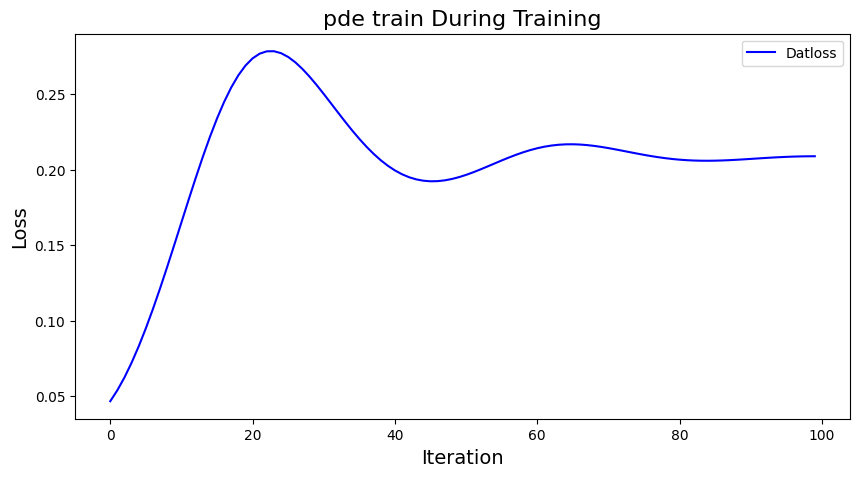

In [27]:
#
# 绘图
plt.figure(figsize=(10, 5))
plt.plot(Loss_List_Adam, color='blue', linewidth=1.5, label='Datloss')
plt.legend()
plt.title('pde train During Training', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
